## Mask out:
- Dwarf galaxies
- Globular clusters
- NGC galaxies
- Sagittarius

Do BASS/Decals separately

In [21]:
import os
import pickle
import sys
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import gala.coordinates as gc
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import healpy as hp
from tqdm.notebook import tqdm
from scipy.optimize import leastsq

from stream_helpers import get_data, rots, apwnorm
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

In [2]:
cubes, distmods, footprints = get_data(
    bass_file='../data/BASS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz', 
    decals_file='../data/DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz',
    stitch=False)

npix, nslice = cubes['bass'].shape
nside = hp.npix2nside(npix)

In [11]:
overlap_mask = (footprints['bass'] & footprints['decals'])

In [45]:
# bins = np.arange(0, 50, 1)
# for i in [0, 30, 50]:
#     plt.figure()
    
#     xx = cubes['decals'][overlap_mask, i]
#     plt.hist(xx, 
#              bins=bins,
#              color='tab:blue', alpha=0.5)
#     plt.axvline(np.median(xx[xx<20]), 
#                 color='tab:blue')
    
#     xx = cubes['bass'][overlap_mask, i]
#     plt.hist(xx, 
#              bins=bins,
#              color='tab:orange', alpha=0.5)
#     plt.axvline(np.median(xx[xx<20]), 
#                 color='tab:orange')
    
#     plt.tight_layout()

# # ---

igrid = np.arange(50)
ratio = np.zeros(len(igrid))
for i in igrid:
    xx = cubes['decals'][overlap_mask, i]
    yy = cubes['bass'][overlap_mask, i]
    ratio[i] = np.mean(yy[yy<15]) / np.mean(xx[xx<15])

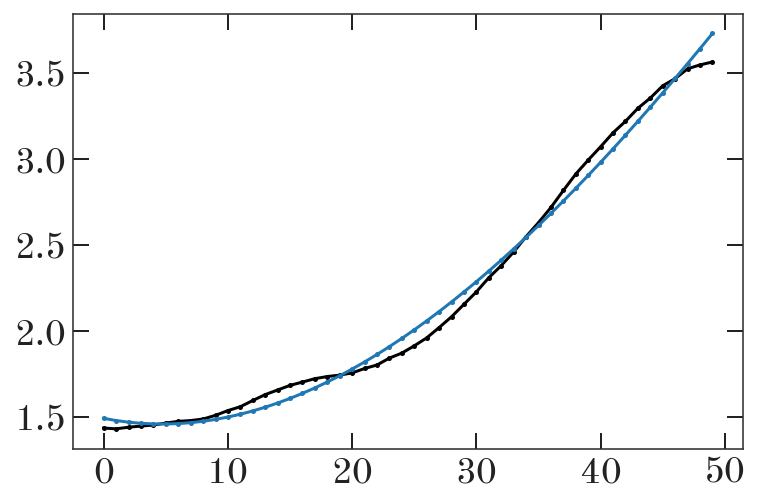

In [50]:
plt.plot(igrid, ratio)
ratio_poly = np.poly1d(np.polyfit(igrid, ratio, deg=3))
plt.plot(igrid, ratio_poly(igrid))

In [51]:
cube = np.zeros_like(cubes['decals'])
cube[footprints['decals']] = cubes['decals'][footprints['decals']]

ratios = ratio_poly(np.arange(nslice))
cube[footprints['bass'] & ~overlap_mask] = cubes['bass'][footprints['bass'] & ~overlap_mask] / ratios[None]

footprint = footprints['decals'] | footprints['bass']

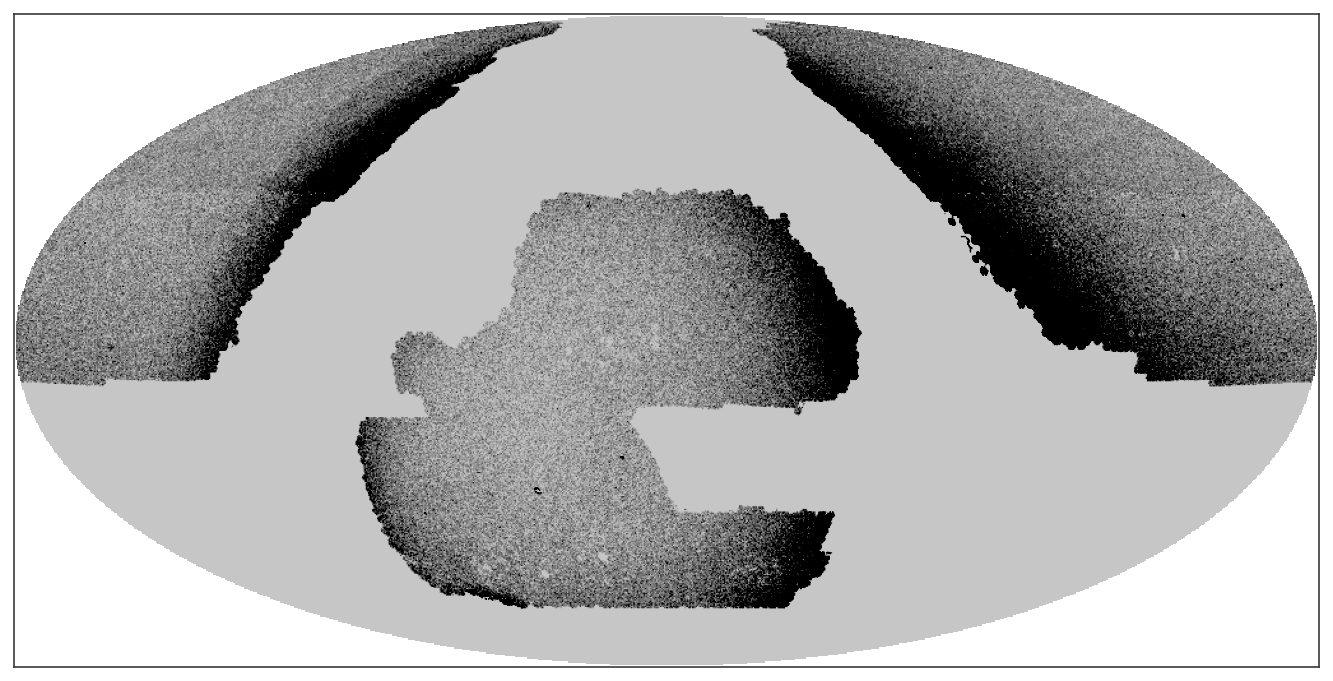

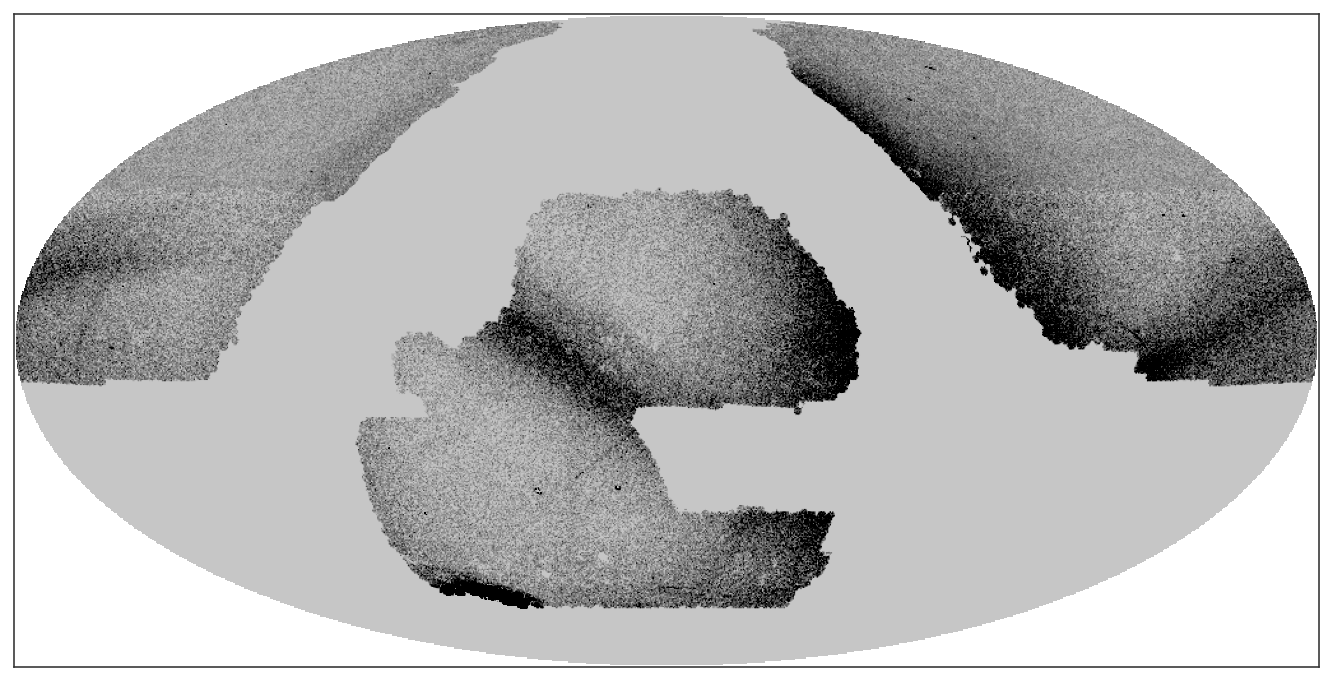

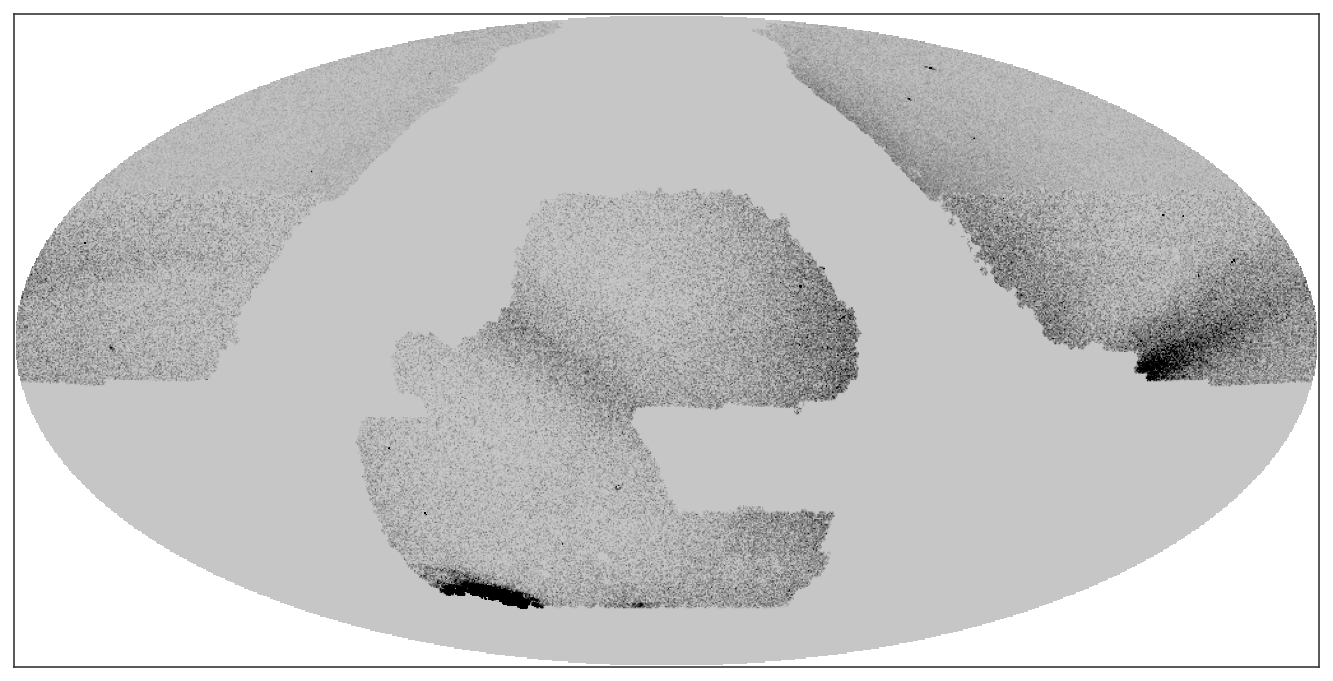

In [52]:
proj = hp.projector.MollweideProj(xsize=1024)# , rot=rots['gal'])

for i in [0, 30, 50]:
    img = proj.projmap(cube[:, i], func)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
              vmin=-5, vmax=1e1, cmap='Greys')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Masking known objects:

In [53]:
all_blobs = at.Table.read('/Users/apricewhelan/data/Misc/MW_dwarfs_globs.fits')
all_blobs = all_blobs[all_blobs['DM'] < 25]

# Special case some half-light radii:
all_blobs['r_h'][all_blobs['name'] == 'SagittariusdSph'] = 2.5 * 60
all_blobs['r_h'][all_blobs['name'] == '#Andromeda'] = 1.5 * 60
all_blobs['r_h'][all_blobs['name'] == 'BootesIII'] = 10
all_blobs['r_h'][all_blobs['name'] == 'LMC'] = 10*60
all_blobs['r_h'][all_blobs['name'] == 'SMC'] = 2.5*60
all_blobs['r_h'][all_blobs['name'] == 'Triangulum'] = 60
all_blobs['r_h'][all_blobs['name'] == 'NGC5904 (M 5)'] /= 2

ngc_tbl = at.Table.read('/Users/apricewhelan/data/Misc/ngc-ic-2000.fit')
ngc_tbl['ra'] = ngc_tbl['RAB2000']
ngc_tbl['dec'] = ngc_tbl['DEB2000']
ngc_tbl['r_h'] = ngc_tbl['size']
ngc_tbl = ngc_tbl[ngc_tbl['size'] > 10]
all_blobs = at.vstack((all_blobs, ngc_tbl))

all_blobs_c = coord.SkyCoord(all_blobs['ra'].data*u.deg,
                             all_blobs['dec'].data*u.deg,
                             coord.Distance(distmod=all_blobs['DM']))

/Users/apricewhelan/projects/astropy-all/astropy/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [54]:
in_footprint_idx = []
for i, cl_c in enumerate(all_blobs_c):
    pix = hp.ang2pix(nside, cl_c.ra.degree, cl_c.dec.degree, 
                     lonlat=True)

    if footprint[pix] or all_blobs['name'][i] in ['LMC', 'SMC']:
        in_footprint_idx.append(True)
    else:
        in_footprint_idx.append(False)

blobs_footprint_idx = np.array(in_footprint_idx)
print(blobs_footprint_idx.sum())

128


Make a mask for bright galaxies and globular clusters:

In [55]:
pix_ang = hp.pix2ang(nside, np.arange(npix), lonlat=True)
pix_c = coord.SkyCoord(pix_ang[0]*u.deg, pix_ang[1]*u.deg)

In [56]:
pix_sag_c = pix_c.transform_to(gc.Sagittarius)
lmc_sag_mask = np.abs(pix_sag_c.Beta) > 15*u.deg

for _name in ['LMC', 'SMC']:
    row = all_blobs[all_blobs['name'] == _name]
    cc = all_blobs_c[all_blobs['name'] == _name]
    lmc_sag_mask &= pix_c.separation(cc) > 3*row['r_h'][0]*u.arcmin

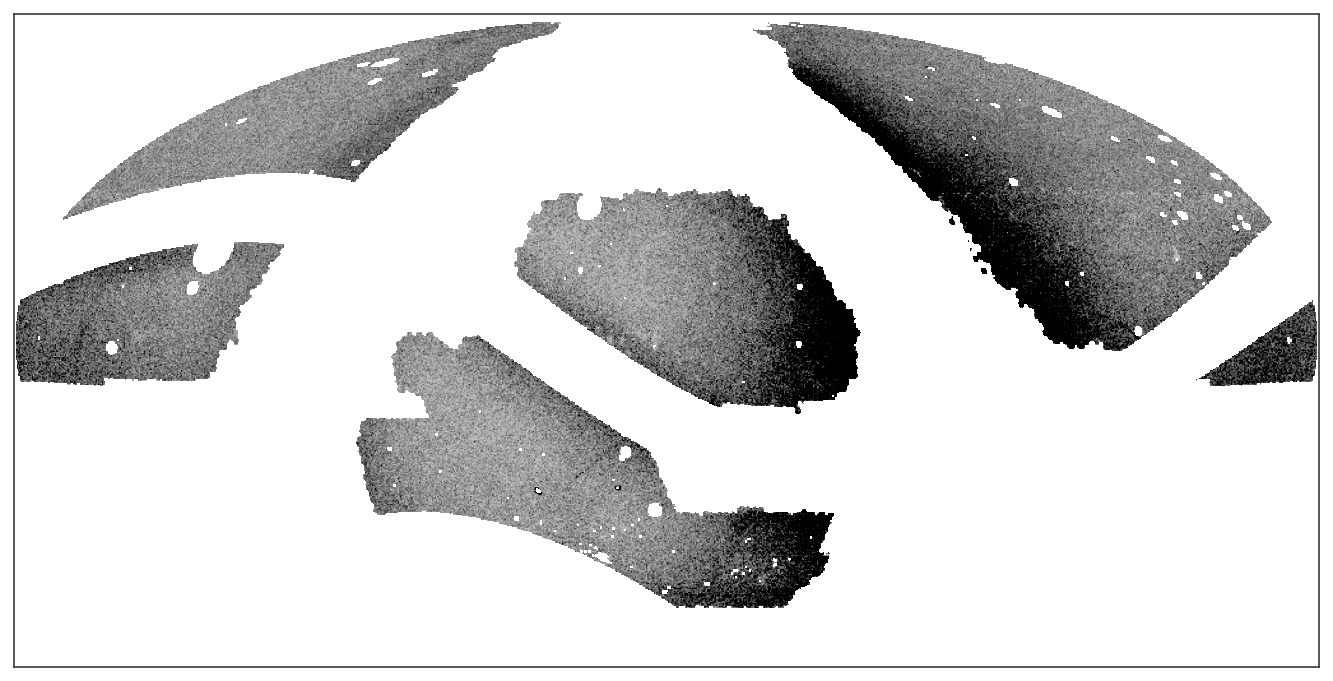

In [57]:
this_blob_mask = np.ones(hp.nside2npix(nside))

for row, cc in zip(all_blobs[blobs_footprint_idx], 
                   all_blobs_c[blobs_footprint_idx]):
    this_blob_mask[pix_c.separation(cc) < 3*row['r_h']*u.arcmin] = 0.

pix_sag = pix_c.transform_to(gc.Sagittarius)
this_blob_mask[np.abs(pix_sag.Beta) < 8*u.deg] = 0.

blob_mask = np.array(1 - this_blob_mask, dtype=bool)

# stacked and masked maps:
stacked_and_masked = np.sum(cube[:, 20:30], axis=1) / 10
stacked_and_masked[blob_mask] = hp.UNSEEN
stacked_and_masked[~footprint] = hp.UNSEEN

# ---

proj = hp.projector.MollweideProj(xsize=1024)# , rot=rots['gal'])
img = proj.projmap(stacked_and_masked, func)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
          vmin=-5, vmax=1e1, cmap='Greys')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [58]:
# Mask out regions
masked_cube = cube.copy()
masked_cube[blob_mask] = hp.UNSEEN
masked_cube[~footprint] = hp.UNSEEN

---

## Starry

In [59]:
import starry
from starry.linalg import solve
from tqdm.notebook import tqdm

# Enable eager evaluation
starry.config.lazy = False

In [ ]:
name = 'decals'
cube = cubes[name]
masked_cube = masked_cubes[name]
footprint = footprints[name]

filename = f'starry_bg_subtracted_{name}.npy'

if not os.path.exists(filename) or True:
    model_cube = np.zeros_like(cube)
    for i in range(cube.shape[1]):
#     for i in [5, 10, 40, 50]:
        print(i)
        slice_mask = footprint & (cube[:, i] >= 0)
        masked_slice_mask = footprint & (masked_cube[:, i] >= 0)

        cube_slice = cube[slice_mask, i]
        masked_cube_slice = masked_cube[masked_slice_mask, i]
        lon, lat = hp.pix2ang(nside, np.arange(npix)[masked_slice_mask], 
                              lonlat=True)

        all_lon, all_lat = hp.pix2ang(nside, np.arange(npix)[slice_mask], 
                                      lonlat=True)
        
        # Compute the design matrix for transformations between alms and intensities
        map = starry.Map(10)
        P = map.intensity_design_matrix(lat=lat, lon=lon)

        # Solve the least squares problem.
        # C is the data covariance (scalar, vector, or matrix)
        # L is the prior covariance (scalar, vector, or matrix)
        # yhat is the posterior mean of the alms
        # cho_yvar is the Cholesky factorization of the posterior covariance
        C = 1.0
        L = 1e-2
        yhat, cho_yvar = solve(P, masked_cube_slice, C=C, L=L, N=P.shape[1])
        
        all_P = map.intensity_design_matrix(lat=all_lat, lon=all_lon)
        model_cube[slice_mask, i] = all_P.dot(yhat)
        # model_cube[slice_mask, i] = P.dot(yhat)
    
    np.save(filename, model_slice)
    
else:
    model_slice = np.load(filename)

0


Pre-computing some matrices... Done.
Compiling `P`... Done.
Compiling `solve`... Done.


1


Pre-computing some matrices... Done.
Compiling `P`... Done.


2


Pre-computing some matrices... Done.
Compiling `P`... Done.


3


Pre-computing some matrices... Done.
Compiling `P`... Done.


4


Pre-computing some matrices... Done.
Compiling `P`... Done.


5


Pre-computing some matrices... Done.
Compiling `P`... Done.


6


Pre-computing some matrices... Done.
Compiling `P`... Done.


7


Pre-computing some matrices... Done.
Compiling `P`... Done.


8


Pre-computing some matrices... Done.
Compiling `P`... Done.


9


Pre-computing some matrices... Done.
Compiling `P`... Done.


10


Pre-computing some matrices... Done.
Compiling `P`... Done.


11


Pre-computing some matrices... Done.
Compiling `P`... Done.


12


Pre-computing some matrices... Done.
Compiling `P`... Done.


13


Pre-computing some matrices... Done.
Compiling `P`... Done.


14


Pre-computing some matrices... Done.
Compiling `P`... Done.


15


Pre-computing some matrices... Done.
Compiling `P`... Done.


16


Pre-computing some matrices... Done.
Compiling `P`... Done.


17


Pre-computing some matrices... Done.
Compiling `P`... Done.


18


Pre-computing some matrices... Done.
Compiling `P`... Done.


19


Pre-computing some matrices... Done.
Compiling `P`... Done.


20


Pre-computing some matrices... Done.
Compiling `P`... Done.


21


Pre-computing some matrices... Done.
Compiling `P`... Done.


22


Pre-computing some matrices... Done.
Compiling `P`... Done.


23


Pre-computing some matrices... Done.
Compiling `P`... Done.


24


Pre-computing some matrices... Done.
Compiling `P`... Done.


25


Pre-computing some matrices... Done.
Compiling `P`... Done.


26


Pre-computing some matrices... Done.
Compiling `P`... Done.


27


Pre-computing some matrices... Done.
Compiling `P`... Done.


28


Pre-computing some matrices... Done.
Compiling `P`... Done.


29


Pre-computing some matrices... Done.
Compiling `P`... Done.


30


Pre-computing some matrices... Done.
Compiling `P`... Done.


31


Pre-computing some matrices... Done.
Compiling `P`... Done.


32


Pre-computing some matrices... Done.
Compiling `P`... Done.


33


Pre-computing some matrices... Done.
Compiling `P`... Done.


34


Pre-computing some matrices... Done.
Compiling `P`... Done.


35


Pre-computing some matrices... Done.
Compiling `P`... Done.


36


Pre-computing some matrices... Done.
Compiling `P`... Done.


37


Pre-computing some matrices... Done.
Compiling `P`... Done.


38


Pre-computing some matrices... Done.
Compiling `P`... Done.


39


Pre-computing some matrices... Done.
Compiling `P`... Done.


40


Pre-computing some matrices... Done.
Compiling `P`... Done.


41


Pre-computing some matrices... Done.
Compiling `P`... Done.


42


Pre-computing some matrices... Done.
Compiling `P`... Done.


43


Pre-computing some matrices... Done.
Compiling `P`... Done.


44


Pre-computing some matrices... Done.
Compiling `P`... Done.


45


Pre-computing some matrices... Done.
Compiling `P`... Done.


46


Pre-computing some matrices... Done.
Compiling `P`... Done.


47


Pre-computing some matrices... Done.
Compiling `P`... Done.


48


Pre-computing some matrices... Done.
Compiling `P`... Done.


49


Pre-computing some matrices... Done.
Compiling `P`... Done.


50


Pre-computing some matrices... Done.
Compiling `P`... Done.


In [37]:
plot_path = '../plots/decals_n'
os.makedirs(plot_path, exist_ok=True)

In [43]:
# proj = hp.projector.GnomonicProj(xsize=1000, ysize=700,
#                                  rot=[0, 0, 0], reso=8)

In [56]:
rots['icrs-180'] = [0,0,0]

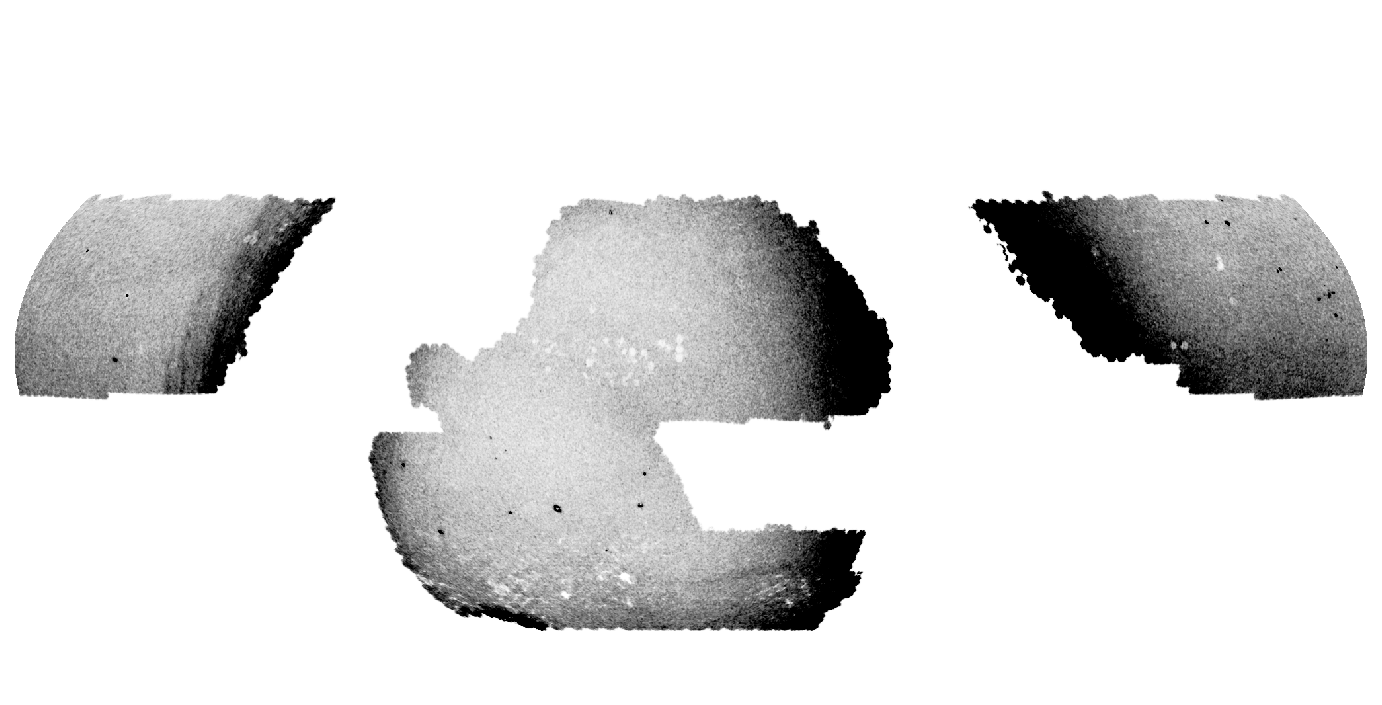

In [151]:
rot_name = 'icrs-180'

rot = rots[rot_name]
proj = hp.projector.MollweideProj(xsize=2048, rot=rot)

i = 10
diff = cubes[name][:, i]
diff = hp.smoothing(diff, sigma=np.radians(0.125), verbose=False)
img = proj.projmap(diff, func)

derp = np.percentile(diff[lmc_sag_mask], [1, 95])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
          vmin=derp[0], vmax=derp[1], cmap='Greys')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for k, sp in ax.spines.items():
    sp.set_visible(False)
ax.set_facecolor('none')
fig.set_facecolor('none')
fig.tight_layout()
fig.savefig(f'{plot_path}/no_starry.png', dpi=250)

In [144]:
# for i in [5, 10, 40, 50]:

rot_name = 'icrs-180'

rot = rots[rot_name]
proj = hp.projector.MollweideProj(xsize=2048, rot=rot)
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

for i in range(model_cube.shape[1]):
    diff = cubes[name][:, i] - model_cube[:, i]
    diff = hp.smoothing(diff, sigma=np.radians(0.125), verbose=False)
    img = proj.projmap(diff, func)
    
    derp = np.percentile(diff[lmc_sag_mask], [1, 99])
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
              vmin=derp[0], vmax=derp[1], cmap='Greys')
    
    # Plot blobs:
    dm_mask = np.abs(all_blobs['DM'] - distmods[i]) < 1.
    blob_mask = (dm_mask & (blobs_footprint_idx[name])).filled(False)
    for blob_name, cc in zip(all_blobs['name'][blob_mask], 
                             all_blobs_c[blob_mask]):
        xy = proj.ang2xy(cc.ra.degree, cc.dec.degree, lonlat=True)
        _name = blob_name.split('(')[0]
        ax.text(xy[0], xy[1], _name, fontsize=5, fontweight='bold', 
                family='dejavu sans', color='tab:red', ha='center', va='bottom')
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for k, sp in ax.spines.items():
        sp.set_visible(False)
    ax.set_facecolor('none')
    fig.set_facecolor('none')
    fig.tight_layout()
    fig.savefig(f'{plot_path}/{rot_name}_labeled_{i:02d}.png', dpi=250)
    plt.close(fig)

In [145]:
diff_cube = cubes[name] - model_cube

In [146]:
slices = [(25, 45),
          (13, 25),
          (3, 13)]

dist = coord.Distance(distmod=distmods)
for x, y in slices:
    print(dist[x], dist[y])

19.952623149688748 kpc 50.11872336272694 kpc
11.481536214968818 kpc 19.952623149688748 kpc
7.244359600749891 kpc 11.481536214968818 kpc


In [147]:
stacks = np.stack([np.sum(diff_cube[:, x:y], axis=1) / (y - x) 
                   for x, y in slices], 
                  axis=-1)

rgb = np.zeros_like(stacks)
for i in range(3):
    X = stacks[..., i]

    # No bg subtrack:
    rgb[..., i] = hp.smoothing(X, sigma=np.radians(0.12), verbose=False)
    rgb[X==0, i] = 0.

for i in range(3):
    X = stacks[..., i]
    
    rgb[..., i] = apwnorm(rgb[..., i], 
                          min=np.percentile(rgb[lmc_sag_mask, i], 1), #2.5), 
                          max=np.percentile(rgb[lmc_sag_mask, i], 99.5))
    
    rgb[X==0, i] = 0.

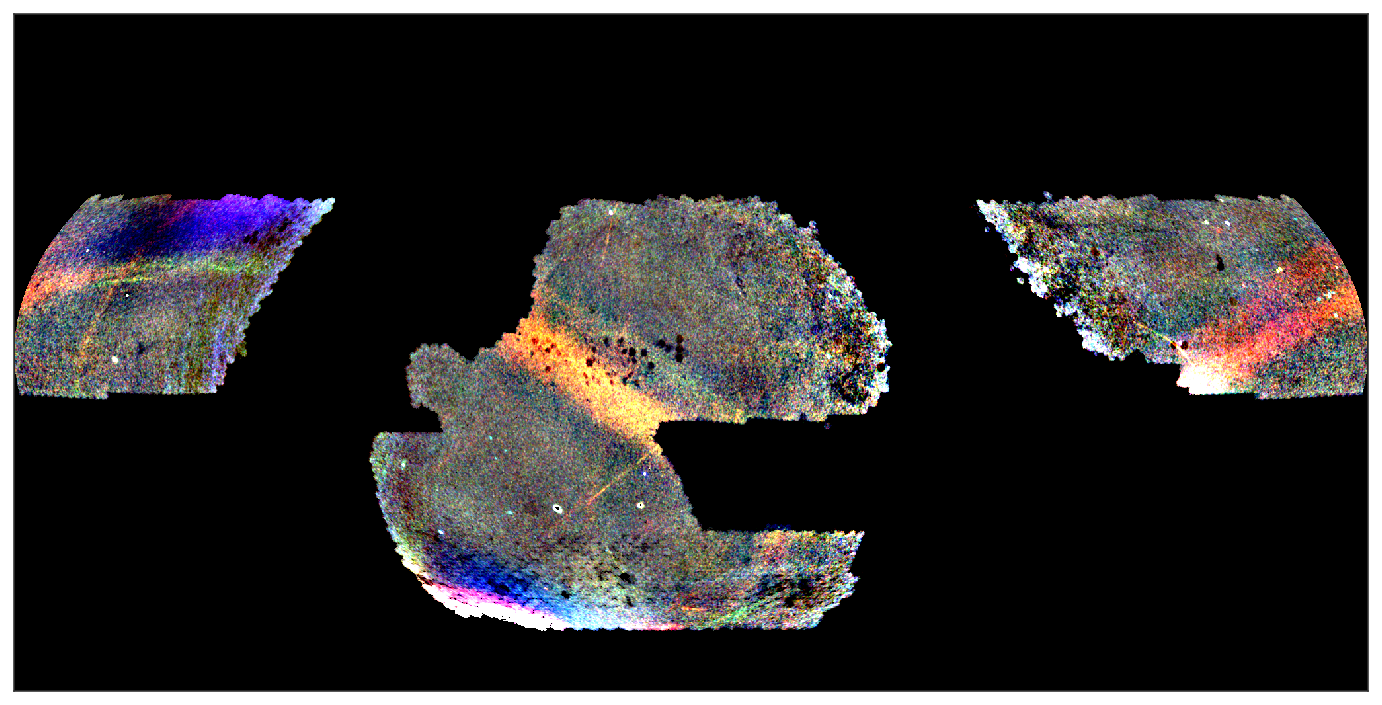

In [148]:
proj = hp.projector.MollweideProj(xsize=2048, rot=rot)
img = np.stack([proj.projmap(rgb[:, i], func) 
                for i in range(3)], axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()
fig.savefig('../plots/psych.png', dpi=250)

---

## One slice:

In [10]:
# name = 'bass'
name = 'decals'
cube = cubes[name]
masked_cube = masked_cubes[name]
footprint = footprints[name]

i = 0
slice_mask = footprint & (cube[:, i] >= 0)
masked_slice_mask = footprint & (masked_cube[:, i] >= 0)

cube_slice = cube[slice_mask, i]
masked_cube_slice = masked_cube[masked_slice_mask, i]
lon, lat = hp.pix2ang(nside, np.arange(npix)[masked_slice_mask], lonlat=True)

all_lon, all_lat = hp.pix2ang(nside, np.arange(npix)[slice_mask], lonlat=True)

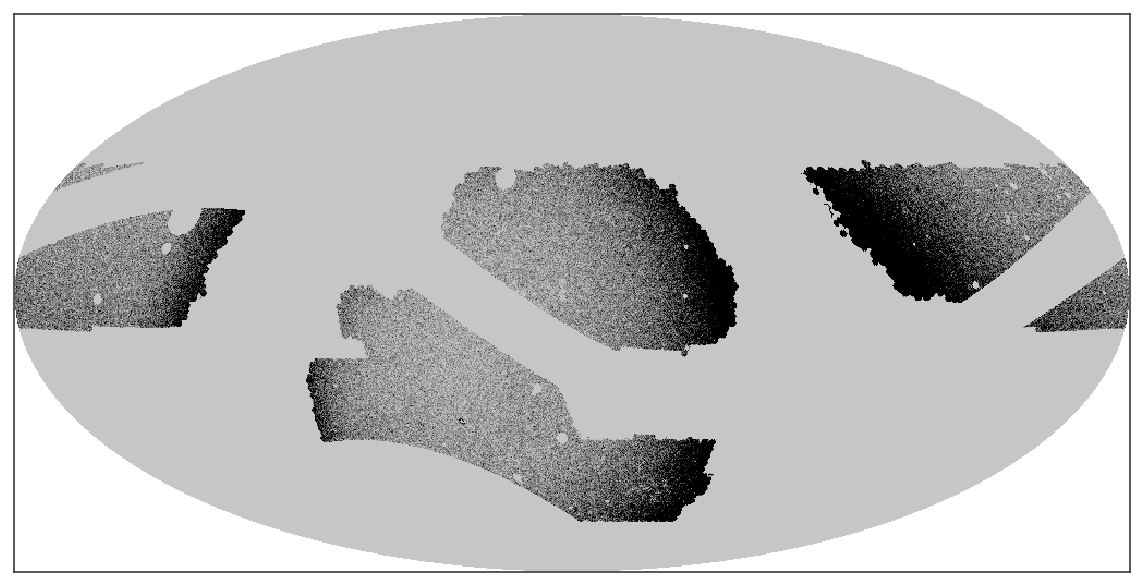

In [11]:
proj = hp.projector.MollweideProj(xsize=1024, rot=[0, 0, 0])
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

# thing = masked_cube[:, i].copy()
# thing[~slice_mask] = hp.UNSEEN
thing = np.zeros(npix)
thing[masked_slice_mask] = masked_cube_slice

img = proj.projmap(thing, func)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
          vmin=-5, vmax=1e1, cmap='Greys')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [13]:
# Compute the design matrix for transformations between alms and intensities
map = starry.Map(10)
P = map.intensity_design_matrix(lat=lat, lon=lon)

Pre-computing some matrices... Done.
Compiling `P`... Done.


In [35]:
# L = np.zeros(P.shape[1])
# j = 0
# for l in range(10+1):
#     for m in range(-l, l+1):
#         if m > 0:
#             L[j] = (1e-2/m)**2
#         else:
#             L[j] = (1e-1)**2
#         j += 1

In [39]:
# Solve the least squares problem.
# C is the data covariance (scalar, vector, or matrix)
# L is the prior covariance (scalar, vector, or matrix)
# yhat is the posterior mean of the alms
# cho_yvar is the Cholesky factorization of the posterior covariance
C = 1.0
L = 1e-1
yhat, cho_yvar = solve(P, masked_cube_slice, C=C, L=L, N=P.shape[1])

In [40]:
all_P = map.intensity_design_matrix(lat=all_lat, lon=all_lon)

model_slice = np.zeros(npix)
model_slice[slice_mask] = all_P.dot(yhat)

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


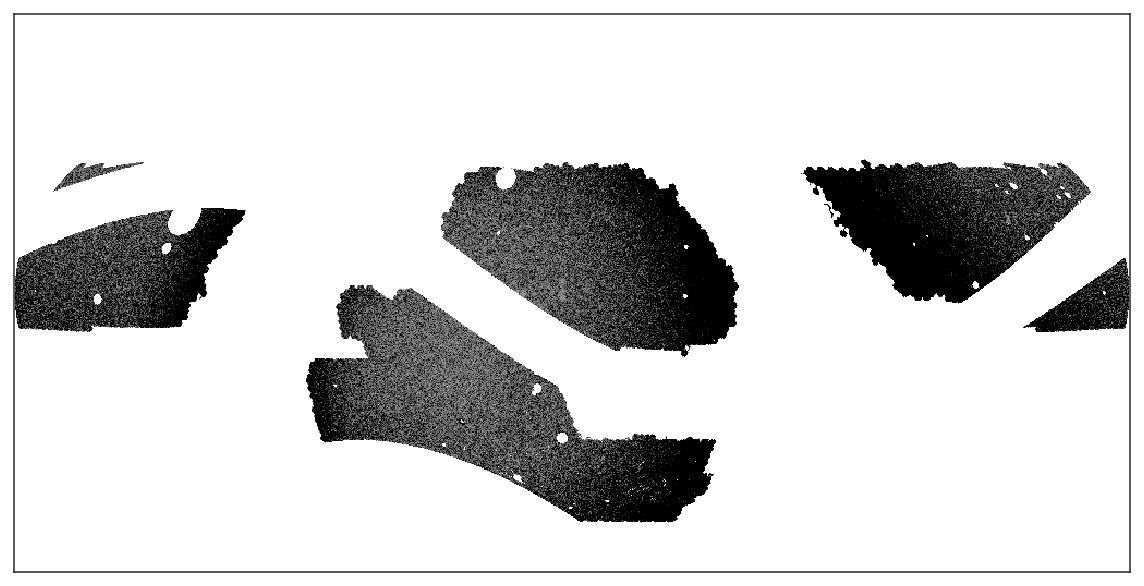

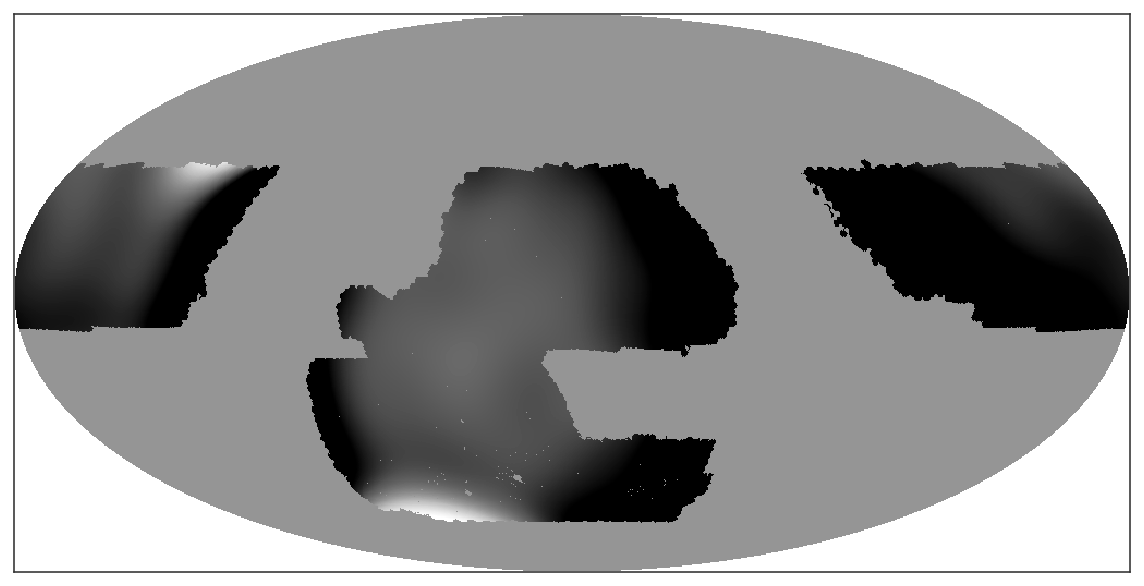

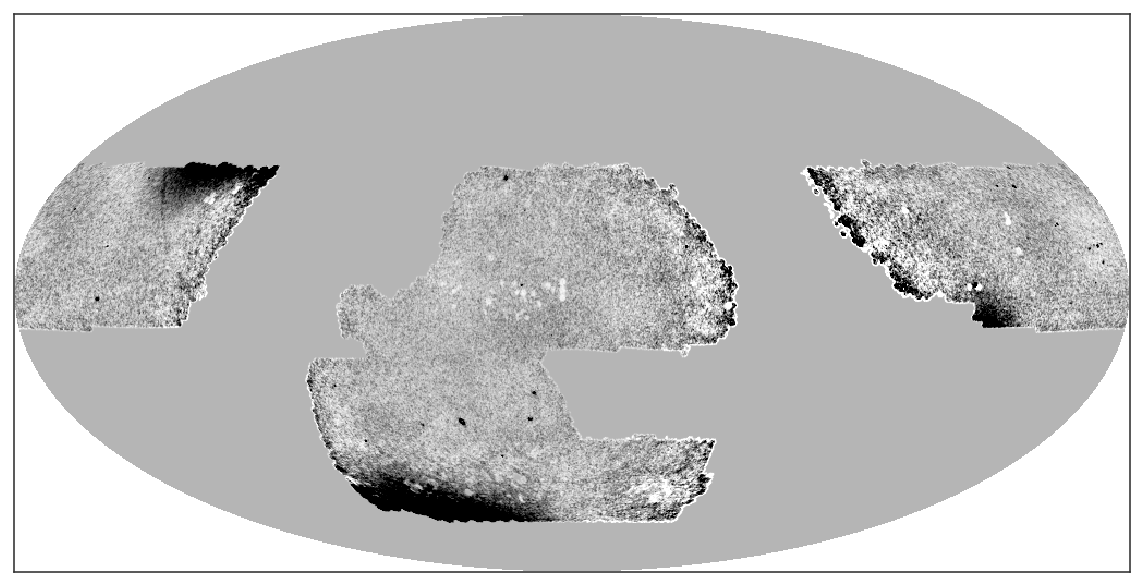

In [42]:
proj = hp.projector.MollweideProj(xsize=1024) #, rot=[-120, 75, -60])
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

for thing in [masked_cube[:, i], model_slice]:
    img = proj.projmap(thing, func)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
              vmin=-5, vmax=5, cmap='Greys')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
# Diff:
diff = cube[:, i] - model_slice
diff[np.abs(diff) > 1e2] = 0

diff = hp.smoothing(diff, sigma=np.radians(0.15))
img = proj.projmap(diff, func)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
          vmin=-2, vmax=3, cmap='Greys')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

Sigma is 9.000000 arcmin (0.002618 rad) 
-> fwhm is 21.193380 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


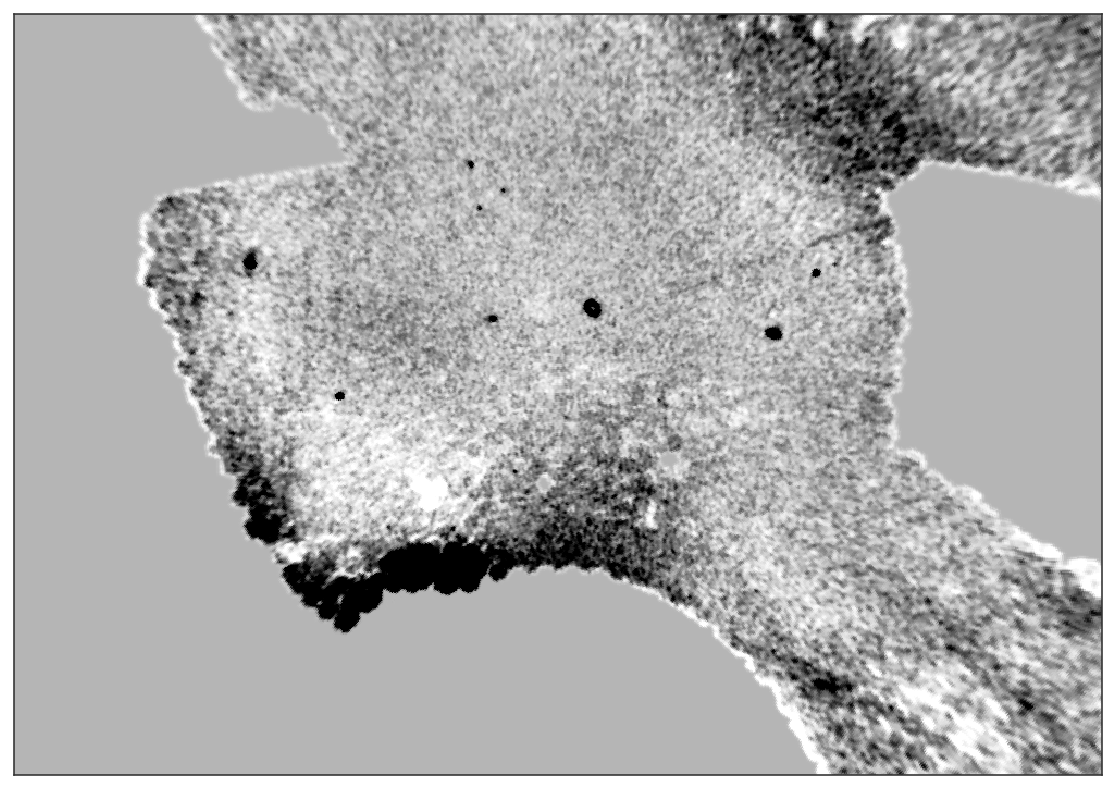

In [35]:
proj = hp.projector.GnomonicProj(xsize=1000, ysize=700,
#                                  rot=[-120, 75, -60], reso=8)
                                 rot=[45, -45, 0], reso=8)

func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

# Diff:
diff = cube[:, i] - model_slice
diff = hp.smoothing(diff, sigma=np.radians(0.15))
img = proj.projmap(diff, func)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.imshow(img, origin='bottom', extent=proj.get_extent(), 
          vmin=-2, vmax=3, cmap='Greys')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)